In [1]:
import ast
import pandas as pd
import numpy as np
import torch
from tensorflow import keras
from tdc.single_pred.adme import ADME
from tdc import Evaluator
from tqdm.notebook import tqdm, trange
from torch.utils.data import TensorDataset, DataLoader
from rdkit import Chem
from rdkit.Chem import AllChem
from matplotlib import pyplot as plt
from IPython import display
from rdkit.Chem import BondType
from rdkit.Chem.Draw import MolsToGridImage
from torch import tensor

from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 250,250



In [2]:
csv_path = keras.utils.get_file(
    "250k_rndm_zinc_drugs_clean_3.csv",
    "https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv",
)

df = pd.read_csv("~/.keras/datasets/250k_rndm_zinc_drugs_clean_3.csv")
df["smiles"] = df["smiles"].apply(lambda s: s.replace("\n", ""))
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249455 entries, 0 to 249454
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   smiles  249455 non-null  object 
 1   logP    249455 non-null  float64
 2   qed     249455 non-null  float64
 3   SAS     249455 non-null  float64
dtypes: float64(3), object(1)
memory usage: 7.6+ MB


In [70]:
SMILE_CHARSET = '["C", "B", "F", "I", "H", "O", "N", "S", "P", "Cl", "Br", None]'  #wyrzucić B, Br,  P, I

bond_mapping = {"SINGLE": 0, "DOUBLE": 1, "TRIPLE": 2, "AROMATIC": 3, "SELF": 4}
bond_mapping.update(
    {0: BondType.SINGLE, 1: BondType.DOUBLE, 2: BondType.TRIPLE, 3: BondType.AROMATIC, 4: "None"}
)
SMILE_CHARSET = ast.literal_eval(SMILE_CHARSET)
MAX_BONDNUM = 150
MAX_MOLSIZE = 64 #max(df["smiles"].str.len())
SMILE_to_index = dict((c, i) for i, c in enumerate(SMILE_CHARSET))
index_to_SMILE = dict((i, c) for i, c in enumerate(SMILE_CHARSET))
atom_mapping = dict(SMILE_to_index)
atom_mapping.update(index_to_SMILE)

BATCH_SIZE = 32
EPOCHS = 500

VAE_LR = 5e-4
NUM_ATOMS = 32  # Maximum number of atoms

ATOM_DIM = len(SMILE_CHARSET)  # Number of atom types
BOND_DIM = 5  # Number of bond types
LATENT_DIM = 128  # Size of the latent space

In [88]:
def edge_idx_to_adj(edge_index, edges_attr):
    #print(edges_attr)
    adj = np.zeros((NUM_ATOMS, NUM_ATOMS))
    attr_matrix = np.zeros((NUM_ATOMS, NUM_ATOMS, BOND_DIM))
    for i in range(edge_index.shape[1]):
        k = edge_index[0][i]
        j = edge_index[1][i]
        print(k, j)
        adj[k][j] = 1
        attr_matrix[k][j] = edges_attr[i]
    return torch.tensor(adj), torch.tensor(attr_matrix)

def batch_edge_idx_to_adj(edge_index, edges_attr):
    adj = np.zeros((BATCH_SIZE*NUM_ATOMS, BATCH_SIZE*NUM_ATOMS))
    attr_matrix = np.zeros((BATCH_SIZE*NUM_ATOMS,BATCH_SIZE*NUM_ATOMS, BOND_DIM))
    adj_reduced = np.zeros((0, NUM_ATOMS))
    attr_reduced = np.zeros((0, NUM_ATOMS, BOND_DIM))
    for i in range(edge_index.shape[1]):
        k = edge_index[0][i]
        j = edge_index[1][i]
        adj[k][j] = 1
        attr_matrix[k][j] = edges_attr[i]
    for i in range(BATCH_SIZE):
        #print(adj.shape, (adj[i*NUM_ATOMS:(i+1)*NUM_ATOMS,i*NUM_ATOMS:(i+1)*NUM_ATOMS]).shape)
        adj_reduced = np.concatenate([adj_reduced, adj[i*NUM_ATOMS:(i+1)*NUM_ATOMS,i*NUM_ATOMS:(i+1)*NUM_ATOMS]], axis=0)
        attr_reduced = np.concatenate([attr_reduced, attr_matrix[i*NUM_ATOMS:(i+1)*NUM_ATOMS,i*NUM_ATOMS:(i+1)*NUM_ATOMS,:]], axis=0)
    return torch.tensor(adj_reduced), torch.tensor(attr_reduced)

def molecule_to_graph(molecule):
    # Converts SMILES to molecule object
    
    mol_atoms = molecule.GetNumAtoms()    # Initialize adjacency and feature tensor
    num_of_bonds = molecule.GetNumBonds()
    edge_index = [[],[]]
    edge_features = []
    adj_mat = np.zeros((NUM_ATOMS, ATOM_DIM))
    
    features = np.zeros((NUM_ATOMS, ATOM_DIM))

    # loop over each atom in molecule
    for atom in molecule.GetAtoms():
        atom_idx = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        atomic_num = atom.GetAtomicNum()
        degree = atom.GetDegree()
        features[atom_idx] = np.eye(ATOM_DIM)[atom_type] #np.concatenate((np.eye(ATOM_DIM)[atom_type][:-2], chem_features), axis=0)
    for i in range(mol_atoms, NUM_ATOMS):
        features[i][ATOM_DIM-1] = 1
        edge_index[0].append(i)
        edge_index[1].append(i)
        edge_embbeding = list(np.eye(BOND_DIM)[BOND_DIM-1])
        edge_features.append(edge_embbeding)
        # loop over one-hop neighbors
    for bond in molecule.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        bond_type_idx = bond_mapping[bond.GetBondType().name]
        edge_index[0] = list(np.append(edge_index[0], [i, j]))
        edge_index[1] = list(np.append(edge_index[1], [j, i]))
        edge_embbeding = list(np.eye(BOND_DIM)[bond_type_idx])
        edge_features.append(edge_embbeding)
        edge_features.append(edge_embbeding)
    return tensor(features), tensor(edge_index), tensor(edge_features)


def graph_to_molecule(graph):  # for edges in adjacency matrix format
    features, adjacency, edge_features = graph

    if adjacency.shape[0] == 2:
       adjacency, edge_features = batch_edge_idx_to_adj(adjacency, edge_features)
    #print(features, adjacency, edge_features)
    # RWMol is a molecule object intended to be edited
    molecule = Chem.RWMol()
    print(adjacency.size())
    for i in range(len(adjacency)):
        adjacency[i][i] = 0

    # Remove "no atoms" & atoms with no bonds
    mol_idx_to_graph_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)
        & (adjacency.sum(axis=1) != 0)
    )
    mol_idx_to_graph_idx = np.squeeze(mol_idx_to_graph_idx)

    graph_idx_to_mol_idx = np.full_like([], fill_value=-1, shape=NUM_ATOMS, dtype=int)
    for mol_idx, graph_idx in enumerate(mol_idx_to_graph_idx):
        graph_idx_to_mol_idx[graph_idx] = mol_idx
    
    for mol_idx, graph_idx in enumerate(mol_idx_to_graph_idx):
        atom_type_idx = int(torch.argmax(features[graph_idx]))
        atom = Chem.Atom(atom_mapping[atom_type_idx])
        _ = molecule.AddAtom(atom)

    for mol_idx_1, graph_idx_1 in enumerate(mol_idx_to_graph_idx):
        for mol_idx_2, graph_idx_2 in enumerate(mol_idx_to_graph_idx):
            if adjacency[graph_idx_1][graph_idx_2] > 0.6 and graph_idx_2 > graph_idx_1:
                #print(edge_features[graph_idx_1][graph_idx_2])
                edge_type_encoded = int(np.argmax(edge_features[graph_idx_1][graph_idx_2]))
                #bond_type = bond_mapping[edge_type_encoded]       
                if edge_type_encoded != 4: molecule.AddBond(int(mol_idx_1), int(mol_idx_2), Chem.BondType.SINGLE)

    flag = Chem.SanitizeMol(molecule, catchErrors=True)

    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        print("Sth went wrong")
        return molecule
    #print("OK")
    return molecule

def adj_to_index(adj_matrix, attr_matrix):
    edge_index=[[], []]
    edge_attr = []
    for i, row in enumerate(adj_matrix):
        adj_matrix[i][i]=0 
        for j in range(len(row)):
            if row[j] == 1:
                edge_index[0].append(i)
                #edge_index[0].append(j)
                #edge_index[1].append(i)
                edge_index[1].append(j)
                edge_embedding = attr_matrix[i][j]
                #edge_type_encoded = np.argmax(edge_embedding)
                edge_attr.append(edge_embedding)
    return torch.tensor(edge_index), torch.tensor(edge_attr)


def concat_features(features, edge_index, edges_attr):
    #print(edges_attr.shape[0], edges_attr)
    if edges_attr.shape[1]==5:
        print("*")
        edges_attr_3d = edge_idx_to_adj(edge_index, edges_attr)[1]
        edges_adj = np.zeros((NUM_ATOMS, NUM_ATOMS), int)
        for i in range(NUM_ATOMS):
            for j in range(NUM_ATOMS):
                edges_adj[i][j]= int(np.argmax(edges_attr_3d[i][j]))
    else: 
        edges_adj = np.zeros((NUM_ATOMS, NUM_ATOMS), int)
        for i in range(NUM_ATOMS):
            for j in range(NUM_ATOMS):
                edges_adj[i][j]= int(np.argmax(edges_attr[i][j]))
    #print(edges_adj)             
    #print(features.shape, edges_adj.shape)
    res = torch.cat((torch.Tensor(features), torch.Tensor(edges_adj)), dim=1)
    return res


In [5]:
z = np.array([[1,2,3]])
y = np.array([[4,5,6]])
np.concatenate([z, y], axis = 0)

array([[1, 2, 3],
       [4, 5, 6]])

In [71]:
from sklearn.discriminant_analysis import StandardScaler
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader


class Featurizer():
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

    def __call__(self, df):
        graphs = []
        labels = []
        for i, row in df.iterrows():
            smiles = row["smiles"]
            molecule = Chem.MolFromSmiles(smiles)
            if molecule.GetNumAtoms() < 32:
                features, edge_index, edge_attr = molecule_to_graph(molecule) 
                features = concat_features(features, edge_index, edge_attr)
                graphs.append((features, edge_index, edge_attr))
                labels.append(molecule)
            
        return [Data(
            features=features.float(), 
            edge_index=edge_index.int(), 
            edge_attr=edge_attr.float(),
            mol=labels)
            for ((features, edge_index, edge_attr), labels) in zip(graphs, labels)]

In [72]:
import sklearn
from sklearn import model_selection
from torch.utils.data import DataLoader

train_data, test_data = model_selection.train_test_split(df, test_size=0.2)

In [73]:
featurizer = Featurizer()
data_train = featurizer(train_data[:1024])
data_val = featurizer(test_data[:128])

from torch_geometric.loader import DataLoader
train_loader = DataLoader(data_train, batch_size=BATCH_SIZE)
val_loader = DataLoader(data_val, batch_size=BATCH_SIZE)

*
tensor(18) tensor(18)
tensor(19) tensor(19)
tensor(20) tensor(20)
tensor(21) tensor(21)
tensor(22) tensor(22)
tensor(23) tensor(23)
tensor(24) tensor(24)
tensor(25) tensor(25)
tensor(26) tensor(26)
tensor(27) tensor(27)
tensor(28) tensor(28)
tensor(29) tensor(29)
tensor(30) tensor(30)
tensor(31) tensor(31)
tensor(0) tensor(1)
tensor(1) tensor(0)
tensor(1) tensor(2)
tensor(2) tensor(1)
tensor(2) tensor(3)
tensor(3) tensor(2)
tensor(3) tensor(4)
tensor(4) tensor(3)
tensor(4) tensor(5)
tensor(5) tensor(4)
tensor(5) tensor(6)
tensor(6) tensor(5)
tensor(6) tensor(7)
tensor(7) tensor(6)
tensor(7) tensor(8)
tensor(8) tensor(7)
tensor(8) tensor(9)
tensor(9) tensor(8)
tensor(9) tensor(10)
tensor(10) tensor(9)
tensor(10) tensor(11)
tensor(11) tensor(10)
tensor(11) tensor(12)
tensor(12) tensor(11)
tensor(12) tensor(13)
tensor(13) tensor(12)
tensor(13) tensor(14)
tensor(14) tensor(13)
tensor(14) tensor(15)
tensor(15) tensor(14)
tensor(11) tensor(16)
tensor(16) tensor(11)
tensor(5) tensor(17)
ten

In [58]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [74]:
def temperature(input, t=1.0):
  return input/t

In [111]:
from torch_geometric.nn import GATConv, global_mean_pool
#import torch.nn.functional as F
from torch.nn.functional import dropout, one_hot
import torch


HIDDEN_SIZE=512

class Encoder(torch.nn.Module):
    def __init__(self, hidden_size=HIDDEN_SIZE, atom_dim = ATOM_DIM, latent_dim=LATENT_DIM):
        super(Encoder, self).__init__()
        torch.manual_seed(12345)

        self.conv = [
            GATConv(atom_dim+NUM_ATOMS, hidden_size),
            GATConv(hidden_size, hidden_size),
            GATConv(hidden_size, hidden_size),
            GATConv(hidden_size, hidden_size),
            GATConv(hidden_size, hidden_size),
            GATConv(hidden_size, hidden_size),
            GATConv(hidden_size, hidden_size),
            GATConv(hidden_size, hidden_size),
            GATConv(hidden_size, hidden_size),
            GATConv(hidden_size, hidden_size)
        ]
        self.pooling = global_mean_pool
        self.dense = [
            torch.nn.Linear(in_features=hidden_size, out_features=hidden_size)
        ]
        self.mean = torch.nn.Linear(in_features=hidden_size, out_features=latent_dim)
        self.std = torch.nn.Linear(in_features=hidden_size, out_features=latent_dim)
        self.elu = torch.nn.ELU() 


    def forward(self, x, edge_index, edge_attr, batch): 
        for conv_layer in self.conv:
            x = conv_layer(x, edge_index, edge_attr)
            x = self.elu(x)    # definiować w konstruktorze
        #print(batch)
        #print("before pooling ", x.shape)
        x = self.pooling(x, batch=batch) #, size = x.shape[1])#[0]
        #print("after pooling ", x.shape)
        #x = torch.flatten(x)
       # print("after flattening ", x.shape)
        for layer in self.dense:
            x = layer(x)
            x = self.elu(x)
        #print("after densing ", x.shape)
        mu, std = self.mean(x), self.std(x)
        #print("mu, std: ", mu.shape, std.shape)
        return mu, std
    
    def loss():
        pass

class Decoder(torch.nn.Module):
    def __init__(self, hidden_size=HIDDEN_SIZE, atom_dim = ATOM_DIM, latent_dim=LATENT_DIM) -> None:
        super(Decoder, self).__init__()
        torch.manual_seed(12345)
        self.edges_from_latent = [
            torch.nn.Linear(in_features=latent_dim, out_features=int(NUM_ATOMS)*int(NUM_ATOMS)),
            torch.nn.Linear(in_features=int(NUM_ATOMS)*int(NUM_ATOMS), out_features=int(NUM_ATOMS)*int(NUM_ATOMS)),
            torch.nn.Linear(in_features=int(NUM_ATOMS)*int(NUM_ATOMS), out_features=int(NUM_ATOMS)*int(NUM_ATOMS)),
            torch.nn.Linear(in_features=int(NUM_ATOMS)*int(NUM_ATOMS), out_features=int(NUM_ATOMS)*int(NUM_ATOMS)),
            torch.nn.Linear(in_features=int(NUM_ATOMS)*int(NUM_ATOMS), out_features=int(NUM_ATOMS)*int(NUM_ATOMS))
        ]

        self.edges_types_from_latent = [
            torch.nn.Linear(in_features=latent_dim, out_features=int(NUM_ATOMS)*int(NUM_ATOMS)*5),
            torch.nn.Linear(in_features=int(NUM_ATOMS)*int(NUM_ATOMS)*5, out_features=int(NUM_ATOMS)*int(NUM_ATOMS)*5),
            torch.nn.Linear(in_features=int(NUM_ATOMS)*int(NUM_ATOMS)*5, out_features=int(NUM_ATOMS)*int(NUM_ATOMS)*5),
            torch.nn.Linear(in_features=int(NUM_ATOMS)*int(NUM_ATOMS)*5, out_features=int(NUM_ATOMS)*int(NUM_ATOMS)*5),
            torch.nn.Linear(in_features=int(NUM_ATOMS)*int(NUM_ATOMS)*5, out_features=int(NUM_ATOMS)*int(NUM_ATOMS)*5),
            torch.nn.Linear(in_features=int(NUM_ATOMS)*int(NUM_ATOMS)*5, out_features=int(NUM_ATOMS)*int(NUM_ATOMS)*5)
        ]

        self.nodes_from_latent = [
            torch.nn.Linear(in_features=latent_dim, out_features=int(NUM_ATOMS)*int(ATOM_DIM)),
            torch.nn.Linear(in_features=int(NUM_ATOMS)*int(ATOM_DIM), out_features=int(NUM_ATOMS)*int(ATOM_DIM)),
            torch.nn.Linear(in_features=int(NUM_ATOMS)*int(ATOM_DIM), out_features=int(NUM_ATOMS)*int(ATOM_DIM)),
            torch.nn.Linear(in_features=int(NUM_ATOMS)*int(ATOM_DIM), out_features=int(NUM_ATOMS)*int(ATOM_DIM)),
            torch.nn.Linear(in_features=int(NUM_ATOMS)*int(ATOM_DIM), out_features=int(NUM_ATOMS)*int(ATOM_DIM)),
            torch.nn.Linear(in_features=int(NUM_ATOMS)*int(ATOM_DIM), out_features=int(NUM_ATOMS)*(int(ATOM_DIM)))
        ]
        self.edges_to_concat = torch.nn.Linear(in_features=(NUM_ATOMS), out_features=(NUM_ATOMS))
        self.elu = torch.nn.ELU()

    def forward(self, z_latent, batch = False):
        edges = torch.clone(z_latent)
        for layer in self.edges_from_latent:
            edges = layer(edges)
            edges = self.elu(edges)

        if batch == False:
            edges = torch.reshape(edges, (NUM_ATOMS, NUM_ATOMS)) + torch.transpose_copy(torch.reshape(edges, (NUM_ATOMS, NUM_ATOMS)), 0, 1)
        else:
            edges_resh = torch.Tensor(size=(0, NUM_ATOMS))
            for row in edges:
                row_reshaped = torch.reshape(row, (NUM_ATOMS, NUM_ATOMS)) + torch.transpose_copy(torch.reshape(row, (NUM_ATOMS, NUM_ATOMS)), 0, 1)
                edges_resh = torch.cat((edges_resh, row_reshaped), 0)
            edges = edges_resh

            if (i := BATCH_SIZE*NUM_ATOMS - edges.size(0)) > 0:
                    edges = torch.cat((edges, torch.zeros(i, NUM_ATOMS)), 0)
        edges = temperature(edges, t=0.2)
        edges_to_concat = torch.clone(edges)
        edges_to_concat = self.edges_to_concat(edges_to_concat)
        edges = torch.sigmoid(edges)


        edges_attr = torch.clone(z_latent)
        for layer in self.edges_types_from_latent:
            edges_attr = layer(edges_attr)
            edges_attr = self.elu(edges_attr)
        if batch == False:
            edges_attr = torch.reshape(edges_attr, (NUM_ATOMS, NUM_ATOMS, 5)) + torch.transpose_copy(torch.reshape(edges_attr, (NUM_ATOMS, NUM_ATOMS, 5)), 0, 1)
        else:
            edges_attr_resh = torch.Tensor(size=(0, NUM_ATOMS, BOND_DIM))
            for row in edges_attr:
                row_reshaped = torch.reshape(row, (NUM_ATOMS, NUM_ATOMS, BOND_DIM)) + torch.transpose_copy(torch.reshape(row, (NUM_ATOMS, NUM_ATOMS, BOND_DIM)), 0, 1)
                edges_attr_resh = torch.cat((edges_attr_resh, row_reshaped), 0)
            edges_attr = edges_attr_resh

            if (i := BATCH_SIZE*NUM_ATOMS - edges_attr.size(0)) > 0:
                    edges_attr = torch.cat((edges_attr, torch.zeros(i, NUM_ATOMS, BOND_DIM)), 0)

        edges_attr = torch.tensor(edges_attr, dtype=float)
        edges_attr = temperature(edges_attr, t=0.3)
        edges_attr = torch.softmax(edges_attr, dim= 1)
        

        nodes = torch.clone(z_latent)
        for layer in self.nodes_from_latent:
            nodes = layer(nodes)
            nodes = self.elu(nodes)
        if batch == False:
            nodes = torch.reshape(nodes, (NUM_ATOMS, ATOM_DIM))
        else:
            nodes_resh = torch.Tensor(size=(0, ATOM_DIM))
            for row in nodes:
                row_reshaped = torch.reshape(row, (NUM_ATOMS, ATOM_DIM))
                nodes_resh = torch.cat((nodes_resh, row_reshaped), 0)
            nodes = nodes_resh

            #if (i := BATCH_SIZE*NUM_ATOMS - nodes.size(0)) > 0:
            #        nodes = torch.cat((nodes, torch.zeros(i, ATOM_DIM)), 0)
    
        nodes = torch.tensor(nodes, dtype=float)
        nodes = temperature(nodes, t=0.3)
        nodes = torch.softmax(nodes, dim= 1)
        #print(nodes.shape, edges_to_concat.shape)
        if edges_to_concat.shape[0] > nodes.shape[0]:
            edges_to_concat = edges_to_concat[:nodes.shape[0]]
        nodes = torch.concat((nodes, edges_to_concat), dim=1)
        return nodes, edges, edges_attr

    def loss():
        pass

 

class GraphNeuralNetwork(torch.nn.Module):  # TODO: assign hyperparameters to attributes and define the forward pass
    def __init__(self, encoder, decoder, hidden_size, atom_dim = ATOM_DIM, latent_dim=LATENT_DIM):
        super(GraphNeuralNetwork, self).__init__()
        torch.manual_seed(12345)

        self.encoder = Encoder(hidden_size)
        self.decoder = Decoder(hidden_size)

        #decode edges:
        
    
    def encode(self, features, edge_index, edge_attr, batch):
        return self.encoder(features, edge_index, edge_attr, batch)

    def reparametrize(self, mu, std):
        eps = torch.randn_like(std)
        z_reparametrized = mu + std*eps
        return z_reparametrized
        

    def decode(self, z_latent, batch = False):
        return self.decoder(z_latent, batch)

    def forward(self, features, adj, edge_attr, batch):
        mu, std = self.encode(features, adj, edge_attr, batch)
        z = self.reparametrize(mu, std)
        batch = True if len(batch)>32 else False
        nodes_dec, edges_dec, edges_attr_dec = self.decode(z, batch)

        return nodes_dec, edges_dec, edges_attr_dec
    

    # def reconstruction_loss(self, nodes_generated, nodes_real, edges_generated, edges_real, edges_attr_generated, edges_attr_real):
    #     loss = torch.nn.CrossEntropyLoss()
    #     nodes_loss = loss(nodes_generated, nodes_real)
    #     edges_loss = loss(edges_generated, edge_idx_to_adj(edges_real))
    #     edges_attr_loss = loss(edges_attr_generated, edges_attr_real)
    #     return nodes_loss + edges_loss + edges_attr_loss

    def eval(self, test_data_loader):
        loss_fn = torch.nn.CrossEntropyLoss()
        loop = tqdm(enumerate(train_loader))
        for i, data in loop:
            data = data.to(device)

            real_features, real_edge_index, real_edge_attr, batch, mol = data.features, data.edge_index.to(dtype=torch.int64), data.edge_attr, data.batch, data.mol
            mu, std = self.encode(real_features, real_edge_index, real_edge_attr, batch)
            z_reparametrized = self.reparametrize(mu, std)

            features_decoded, edges_decoded, edges_attr_decoded = self.decode(z_reparametrized, batch=True)
                
            real_adj_edges, real_adj_edge_attr = batch_edge_idx_to_adj(real_edge_index, real_edge_attr)

            features_loss = loss_fn(one_hot(torch.argmax(features_decoded, dim=1), num_classes = ATOM_DIM).to(torch.float64), real_features)
            edges_loss = loss_fn(edges_decoded, real_adj_edges)
            edges_attr_loss = loss_fn(one_hot(torch.argmax(edges_attr_decoded, dim=2), num_classes = BOND_DIM).to(torch.float64), real_adj_edge_attr)

            reconstruction_loss = features_loss + edges_loss + edges_attr_loss
            kl_div = -torch.sum(1 + torch.log(std.pow(2)) - mu.pow(2) - std.pow(2))
            loss = 5*reconstruction_loss + kl_div
            print("feat, edges, edges_attr, kl ", features_loss, edges_loss, edges_attr_loss, kl_div)
            print("total ", loss)



In [112]:
encoder = Encoder(hidden_size=HIDDEN_SIZE)
decoder = Encoder(hidden_size=HIDDEN_SIZE)

encoder=encoder.float()
decoder = decoder.float()
g = GraphNeuralNetwork(hidden_size=512, encoder=encoder, decoder=decoder)
#g=g.float()


In [90]:
from numpy import int64
from torch.nn.functional import one_hot

def train(model, train_loader, valid_loader, l_r = 0.00001, epochs = 1000):
        learning_rate = l_r
        #entropy_fn = torch.nn.Entropy() # TODO <- for delete uncertainity
        optimizer = torch.optim.Adam(params=model.parameters(), lr= learning_rate)
        loss_fn = torch.nn.CrossEntropyLoss()
        for epoch in trange(1, epochs + 1, leave=False):
            loop = tqdm(enumerate(train_loader))
            for i, data in loop:
                data = data.to(device)

                real_features, real_edge_index, real_edge_attr, batch, mol = data.features, data.edge_index.to(dtype=torch.int64), data.edge_attr, data.batch, data.mol
                mu, std = model.encode(real_features, real_edge_index, real_edge_attr, batch)
                z_reparametrized = model.reparametrize(mu, std)

                features_decoded, edges_decoded, edges_attr_decoded = model.decode(z_reparametrized, batch=True)
                real_adj_edges, real_adj_edge_attr = batch_edge_idx_to_adj(real_edge_index, real_edge_attr)

                features_loss = loss_fn(features_decoded, real_features)
                edges_loss = loss_fn(edges_decoded, real_adj_edges)
                edges_attr_loss = loss_fn(edges_attr_decoded, real_adj_edge_attr)

                reconstruction_loss = features_loss + edges_loss + edges_attr_loss
                kl_div = -torch.sum(1 + torch.log(std.pow(2)) - mu.pow(2) - std.pow(2))
                loss = 5*reconstruction_loss + kl_div
                print(loss)
                loss.backward()
                optimizer.step() 
                optimizer.zero_grad()
                model.zero_grad()


In [89]:
from torch.nn.functional import one_hot

loop = tqdm(enumerate(val_loader))
for i, data in loop:
    if i > 0:
        break

    real_features, real_edge_index, real_edge_attr, batch, mol = data.features, data.edge_index.to(dtype=torch.int64), data.edge_attr, data.batch, data.mol
    mu, std = g.encode(real_features, real_edge_index, real_edge_attr, batch)
    z_reparametrized = g.reparametrize(mu, std)
    features_decoded, edges_decoded, edges_attr_decoded = g.decode(z_reparametrized, batch = True)
    f, e, e_a = features_decoded[:32], edges_decoded[:32], edges_attr_decoded[:32]
    f = one_hot(torch.argmax(f, dim=1), num_classes = ATOM_DIM).to(torch.float64)
    e_a = one_hot(torch.argmax(e_a, dim=2), num_classes = BOND_DIM).to(torch.float64)
    print(f.size(), e.size(), e_a.size())
    mol = graph_to_molecule((f, e, e_a))
    mol = Chem.rdchem.Mol(mol)


0it [00:00, ?it/s]

torch.Size([32, 12]) torch.Size([32, 32]) torch.Size([32, 32, 5])
torch.Size([32, 32])


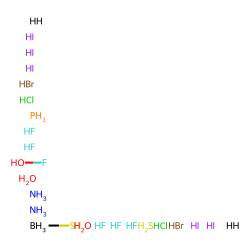

In [ ]:
mol

In [80]:
mol = graph_to_molecule((f, e, e_a))

torch.Size([32, 32])


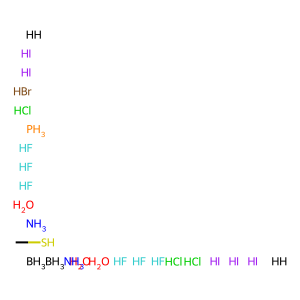

In [81]:
Draw.MolToImage(mol) 

In [119]:
train(g, train_loader=train_loader, valid_loader=val_loader, epochs = 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

tensor(1780.7664, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1771.7815, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1739.3206, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1749.3910, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1725.3172, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1750.5467, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1773.1862, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1741.5317, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1815.6979, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1847.5003, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1790.5207, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1732.1278, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1780.2745, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1773.6614, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1793.7895, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1753.6072, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1751.9966, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1750.1037, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1716.0831, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1732.5068, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1705.7997, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1729.0475, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1761.1848, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1721.2110, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1800.4637, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1826.2478, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1773.8831, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1720.7335, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1772.4164, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1765.0822, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1775.4238, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1739.9825, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1752.7775, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1736.6712, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1705.0737, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1719.0329, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1698.9941, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1719.3415, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1747.5240, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1711.0765, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1784.3271, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1816.2908, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1765.5507, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1707.5255, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1765.0800, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1750.9323, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1763.4152, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1728.7193, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1751.1587, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1730.0151, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1695.1015, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1711.0262, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1687.9003, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1713.5969, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1737.6235, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1701.8009, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1778.7799, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1805.4661, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1754.9271, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1705.4547, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1752.7813, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1739.7388, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1752.7376, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1721.7843, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1736.9802, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1721.2256, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1686.4224, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1702.4142, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1678.9611, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1698.1227, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1728.6164, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1692.3151, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1771.9158, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1796.4090, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1745.6818, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1697.9319, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1742.9627, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1732.1504, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1743.6427, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1709.3701, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1733.5587, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1706.4838, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1676.6075, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1693.6531, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1667.6369, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1691.0460, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1721.5051, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1683.0910, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1757.6405, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1792.7957, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1743.1905, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1683.8352, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1742.5614, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1721.3464, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1735.2894, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1700.1112, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1713.0122, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1688.0631, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1658.6506, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1680.9079, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1665.9363, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1673.6480, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1716.0383, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1675.3000, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1740.1345, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1773.0858, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1725.6023, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1661.1379, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1718.5539, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1705.9895, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1731.2894, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1694.5641, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1708.7846, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1677.7056, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1646.0827, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1676.3758, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1657.0930, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1662.5638, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1708.9400, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1671.0237, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1726.4930, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1761.2305, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1713.4835, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1650.0195, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1707.1211, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1687.9120, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1722.8310, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1685.8602, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1699.1696, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1670.6248, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1639.3668, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1665.4950, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1647.6541, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1655.6978, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1699.1644, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1660.6390, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1721.9455, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1754.3322, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1708.3598, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1649.8510, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1700.2082, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1687.4286, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1714.2436, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1676.9844, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1692.7308, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1663.0205, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1631.4314, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1657.5398, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1639.6314, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1647.5595, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1690.7775, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1652.1888, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1714.6413, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1746.0678, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1701.6190, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1638.5606, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1692.5565, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1679.4914, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1704.5200, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1669.0681, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1683.8990, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1653.6696, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1622.7017, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1651.6816, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1631.8549, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1639.4714, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1692.3685, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1648.0049, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1699.9301, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1738.8858, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1690.2362, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1625.2702, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1682.8468, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1660.8534, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1686.1549, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1661.3851, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1668.5517, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1640.2748, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1611.6988, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1647.2617, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1621.8244, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1632.7623, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1678.6582, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1641.2897, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1683.2309, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1722.1940, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1676.9145, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1612.1816, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1681.1228, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1648.4102, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1672.9501, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1649.7967, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1660.3950, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1633.1743, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1604.5373, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1639.9851, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1614.7627, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1628.4477, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1669.1796, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1633.4259, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1677.2481, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1715.1979, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1672.7765, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1607.7990, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1670.3110, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1643.0151, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1670.9353, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1643.6585, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1654.5669, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1627.3126, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1597.5038, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1633.4687, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1608.0324, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1619.0288, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1661.4617, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1626.6169, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1670.4880, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1708.0074, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1666.6007, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1600.9587, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1663.2663, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1636.1522, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1665.1498, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1636.4359, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1647.0071, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1620.1118, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1590.7590, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1626.2746, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1600.7074, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1612.1456, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1655.3593, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1619.4746, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1663.4419, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1700.8162, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1658.3449, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1593.5344, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1657.1765, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1628.9110, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1660.8645, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1629.8449, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1641.7511, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1614.3931, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1584.4761, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1622.0836, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1595.3127, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1609.6859, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1647.5615, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1614.2800, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1658.3253, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1694.5001, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1658.2526, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1589.6333, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1649.3258, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1623.9878, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1648.4978, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1624.6235, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1634.3246, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1607.3687, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1577.7846, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1613.8333, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1587.2844, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1599.0665, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1641.5336, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1607.0361, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1650.9999, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1687.3224, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1649.7443, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1581.4627, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1644.0981, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1616.2256, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1642.1459, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1616.8506, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1628.6232, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1600.0258, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1571.6853, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1607.4615, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1579.7271, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1589.1981, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1640.6104, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1603.9614, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1642.2797, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1679.3915, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1634.7015, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1571.9124, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1640.3567, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1607.8949, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1631.5913, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1610.2174, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1623.7518, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1592.6863, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1566.5912, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1607.6487, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1573.4704, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1580.8905, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1632.1788, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1597.8641, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1635.4663, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1673.2670, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1627.5524, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1565.2277, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1633.6531, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1601.6814, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1624.8530, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1604.0858, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1617.8990, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1587.0915, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1560.6025, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1597.7183, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1567.3904, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1574.5928, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1626.1796, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1589.5479, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1629.0521, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1668.8803, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1620.8338, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1559.1221, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1627.0877, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1595.1338, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1617.5611, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1599.0029, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1614.5546, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1581.0395, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1555.4576, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1593.4823, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1561.5278, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1568.3498, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1620.3274, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1583.8807, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1623.4822, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1661.9718, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1614.9099, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1553.5547, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1621.5083, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1589.7897, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1612.1870, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1592.6871, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1606.5934, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1576.1249, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1549.1565, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1586.7613, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1556.2185, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1563.1715, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1614.7778, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1577.7457, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1617.5010, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1656.6253, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1609.0124, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1547.9065, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1615.8961, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1584.0287, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1606.3707, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1587.3147, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1602.4265, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1569.9175, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1543.9432, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1582.5949, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1550.0076, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1557.2390, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1609.4243, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1572.0480, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1612.1861, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1650.4557, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1603.5921, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1542.7565, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1610.0497, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1578.2867, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1601.2110, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1581.7419, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1596.4161, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1564.4682, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1538.3668, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1575.9048, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1544.6404, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1551.9546, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1603.7191, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1566.6697, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1606.7186, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1644.9886, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1597.7388, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1537.2266, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1604.5684, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1573.1146, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1595.2257, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1576.4830, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1591.6367, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1559.5310, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1533.3378, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1571.0383, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1539.4088, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1547.1315, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1598.5069, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1561.3578, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1601.6677, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1639.0872, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1592.5566, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1532.0176, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1599.4994, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1568.0138, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1590.1523, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1571.1229, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1586.2424, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1554.1698, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1527.8860, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1565.7263, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1534.1624, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1541.7404, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1593.5670, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1556.2856, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1596.3434, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1633.4730, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1587.3583, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1527.0488, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1593.9023, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1562.9039, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1584.7160, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1565.8463, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1581.8605, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1549.4929, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1523.1802, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1560.6209, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1529.1371, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1536.7651, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1588.4991, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1551.2034, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1591.1133, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1628.1539, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1582.0421, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1522.3789, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1588.9622, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1557.8616, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1579.9597, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1560.9510, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1576.2611, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1544.7750, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1518.4661, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1555.8794, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1524.0137, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1531.9285, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1583.6795, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1546.2066, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1586.1401, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1623.0734, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1577.1111, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1517.3094, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1584.1237, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1552.8789, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1575.0973, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1555.8265, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1571.8097, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1539.6099, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1513.0986, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1551.0967, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1519.1621, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1527.0870, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1578.8828, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1540.9968, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1581.6341, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1617.9931, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1572.1269, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1512.8088, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1579.3329, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1548.2488, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1570.4100, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1550.9936, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1566.6984, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1534.8348, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1508.6305, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1546.2796, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1514.5916, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1522.1531, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1574.0717, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1536.5072, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1576.9723, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1613.2418, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1567.3913, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1507.9533, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1574.6124, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1543.4947, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1565.3140, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1546.5591, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1561.9714, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1530.4691, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1503.9207, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1541.5240, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1509.8416, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1517.5799, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1569.7981, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1531.5409, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1572.0617, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1607.9197, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1562.4831, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1503.4564, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1569.9514, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1539.1981, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1560.8622, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1542.0440, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1557.5769, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1525.9701, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1499.3878, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1537.0731, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1505.2247, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1512.8275, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1565.3560, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1526.9732, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1567.2797, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1603.1392, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1558.0391, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1498.9606, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1565.5357, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1534.7748, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1556.2161, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1537.1034, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1553.3142, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1521.2866, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1495.1251, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1532.5317, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1500.8479, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1508.4668, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1560.6978, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1522.4123, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1562.8932, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1598.3281, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1553.4768, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1494.5345, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1560.9348, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1530.0073, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1551.8507, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1532.8374, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1548.4160, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1517.1248, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1490.3677, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1528.2440, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1496.3949, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1504.3834, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1556.6159, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1517.9846, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1558.6381, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1594.2308, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1549.0321, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1490.4866, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1556.3331, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1526.3068, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1547.3635, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1528.4695, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1544.3292, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1512.7617, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1486.3142, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1523.8848, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1492.0589, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1499.9859, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1552.1258, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1513.9025, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1554.4882, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1589.4239, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1544.6154, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1486.2523, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1552.0924, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1521.8925, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1543.0246, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1523.8312, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1539.9354, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1508.7105, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1482.0077, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1519.8106, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1487.8413, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1495.5211, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1548.2146, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1509.5666, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1550.1134, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1584.7580, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1540.0702, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1482.1754, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1547.8141, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1517.7443, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1538.7895, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1519.8379, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1536.0843, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1504.3136, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1477.9183, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1515.7418, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1483.9929, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1491.8263, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1543.9303, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1505.3802, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1545.8377, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1580.4870, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1536.1854, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1478.2359, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1543.4635, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1513.7402, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1534.6361, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1515.4060, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1532.0977, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1500.6999, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1474.0006, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1511.8363, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1479.8008, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1487.5567, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1540.0680, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1501.5531, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1541.7724, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1576.2458, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1531.8763, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1473.9351, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1539.9712, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1509.5785, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1530.6092, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1511.5704, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1528.4812, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1496.6302, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1469.7874, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1507.5154, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1475.9161, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1483.7903, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1536.1239, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1497.4223, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1537.9057, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1571.8850, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1527.9764, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1470.5940, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1535.7286, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1505.7715, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1526.7268, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1507.3726, dtype=torch.float64, grad_fn=<AddBack

In [ ]:
# wykres latent space po logP

In [ ]:
from scipy.stats import entropy
v = [[0.0,1.0],[0.5,0.5]]
w = [0.5]
z = [0.1]

print(entropy(v), entropy(w), entropy(z))

[0.         0.63651417] 0.0 0.0
